# Import libraries and set CSV directory

In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
# import os
# import gzip

data_dir = "../mimic-iii-clinical-database-demo-1.4"

## Set individual dataframes

In [162]:
patients_df = pd.read_csv(data_dir + str('/') + 'PATIENTS.csv', encoding='unicode_escape')
admissions_df = pd.read_csv(data_dir + str('/') + 'ADMISSIONS.csv', encoding='unicode_escape')
diagnoses_df = pd.read_csv(data_dir + str('/') + 'DIAGNOSES_ICD.csv', encoding='unicode_escape')
icu_stays_df = pd.read_csv(data_dir + str('/') + 'ICUSTAYS.csv', encoding='unicode_escape')
services_df = pd.read_csv(data_dir + str('/') + 'SERVICES.csv', encoding='unicode_escape')
transfers_df = pd.read_csv(data_dir + str('/') + 'TRANSFERS.csv', encoding='unicode_escape')
prescriptions_df = pd.read_csv(data_dir + str('/') + 'PRESCRIPTIONS.csv', encoding='unicode_escape')
diagnoses_labels_df = pd.read_csv(data_dir + str('/') + 'D_ICD_DIAGNOSES.csv', encoding='unicode_escape')

microbiology_events_df = pd.read_csv(data_dir + str('/') + 'MICROBIOLOGYEVENTS.csv', encoding='unicode_escape')  

In [163]:
# print('======================patients=====================')
# patients.info()
# print('======================admissions=====================')
# admissions.info()
# print('======================diagnoses=====================')
# diagnoses.info()
# print('======================icu_stays=====================')
# icu_stays.info()
# print('=====================services=====================')
# services.info()
# print('======================transfers=====================')
# transfers.info() 
# print('======================prescriptions=====================')
# prescriptions.info()
# print('======================diagnose_labels=====================')
# diagnoses_labels.info()

## Calculate patient age

In [164]:
from datetime import datetime

# Calculate age function
def calculate_age(dob, dod):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    if pd.isna(dod):
        return None
    dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")
    age = (dod_date - dob_date).days // 365
    return age

# Apply calculate_age function to create "age" column
patients_df["age"] = patients_df.apply(lambda row: calculate_age(row["dob"], row["dod"]), axis=1)

# Filter out rows with age greater than or equal to 120
filtered_patients_df = patients_df[patients_df["age"] < 120]

# Display the updated DataFrame
# print(filtered_patients_df.head())

## ICU stays & prescriptions table

In [165]:
# Merge admissions and patients data on subject_id
icu_presc_merged_data = pd.merge(icu_stays_df, prescriptions_df, on="subject_id")
# icu_presc_merged_data.head()
# icu_presc_merged_data["drug"].value_counts()

## Create bar plot for frequent prescriptions

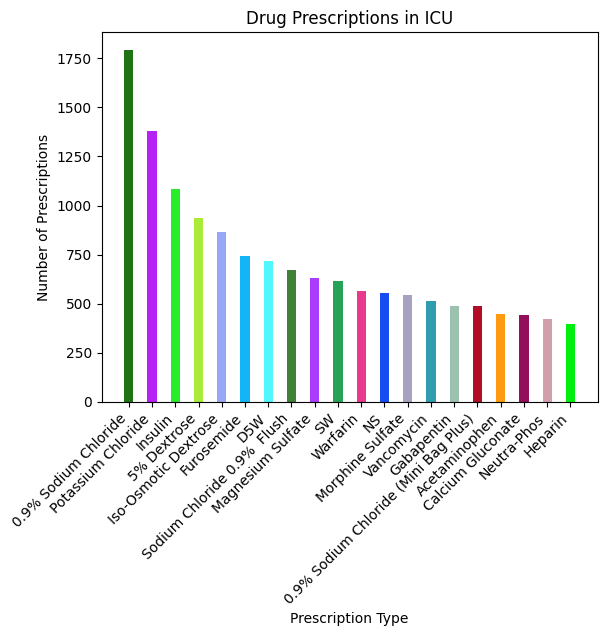

In [167]:
# Calculate unique values and their counts
unique_values, counts = np.unique(icu_presc_merged_data['drug'], return_counts=True)

# Sort by counts in descending order
sorted_indices = np.argsort(-counts)
sorted_values = unique_values[sorted_indices]

# Get the top 20 most frequent prescriptions
frequent_prescriptions = sorted_values[:20]

# Get the number of occurrences for the top 20 most frequent prescriptions
occurrences = icu_presc_merged_data['drug'].value_counts()
top_20_occurrences = occurrences[frequent_prescriptions]

# Create a list of random colors
colors = np.random.rand(len(unique_values), 3)

# creating the bar plot
plt.bar(frequent_prescriptions, top_20_occurrences, color=colors, 
        width = 0.4)

plt.xlabel("Prescription Type")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Prescriptions")
plt.title("Drug Prescriptions in ICU")

plt.show()

## Most frequent hours for ICU admissions/discharges

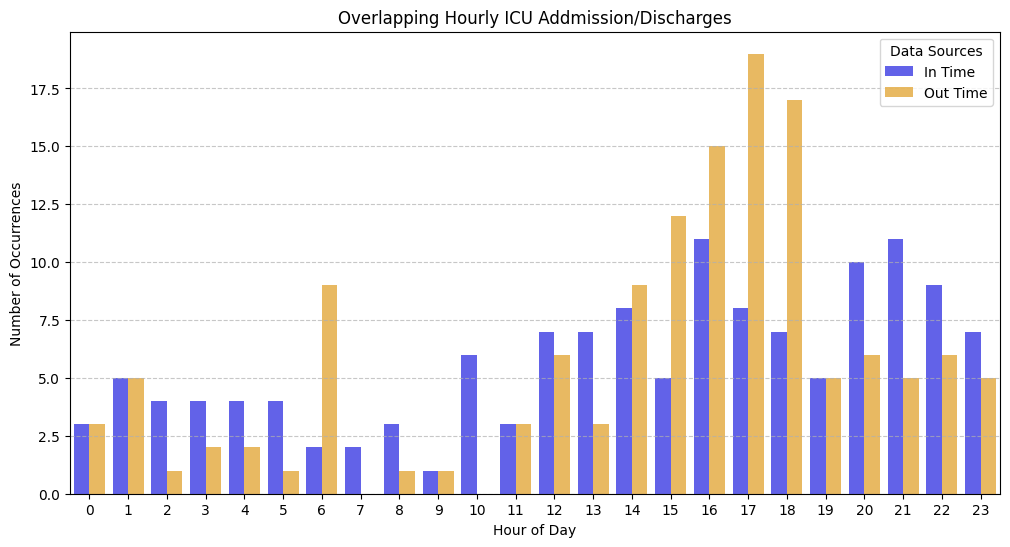

In [122]:
# Datetime conversion
icu_stays_df['hour_in_time'] = pd.to_datetime(icu_stays_df['intime']).dt.hour
icu_stays_df['hour_out_time'] = pd.to_datetime(icu_stays_df['outtime']).dt.hour

common_in_times = icu_stays_df['hour_in_time'].value_counts()
common_in_times = common_in_times.sort_index()  # Sort by hour of day
hour_in_time = pd.Series(common_in_times, index=np.arange(24), name='hour_in_time')

common_out_times = icu_stays_df['hour_out_time'].value_counts()
common_out_times = common_out_times.sort_index()  # Sort by hour of day
hour_out_time = pd.Series(common_out_times, index=np.arange(24), name='hour_out_time')

# Combine the data into a single DataFrame
data = pd.DataFrame({
    "Hour": np.arange(24),
    "In Time": hour_in_time,
    "Out Time": hour_out_time
})

# Melt the Dataframe for Seaborn compatibility
# Keeps Hour column as-is (it won’t be melted)
# Names column for original column names (In Time and Out Time) to Type
# Names column for corresponding values from (In Time and Out Time) to Count
data_melted = data.melt(id_vars="Hour", var_name="Time Type", value_name="Count")

# Plot the data using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=data_melted, x="Hour", y="Count", hue="Time Type", alpha=0.7, palette=["blue", "orange"])

# Customize the plot
plt.xlabel("Hour of Day")
plt.ylabel("Number of Occurrences")
plt.title("Overlapping Hourly ICU Addmission/Discharges")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Data Sources")    

# Show the plot
plt.show()

## Common Diagnoses for Men

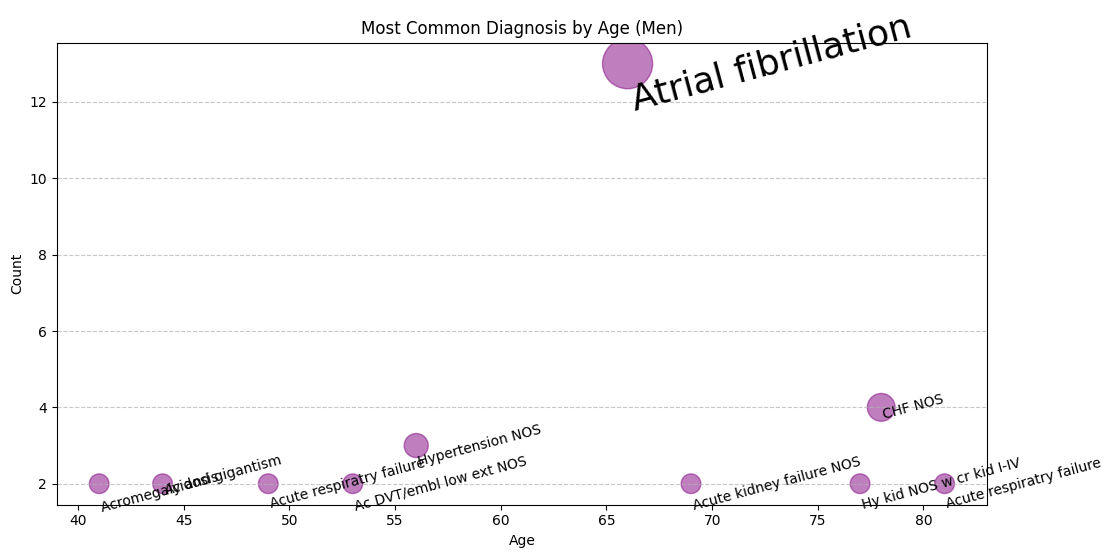

In [248]:
merged_diagnoses_data = pd.merge(diagnoses_df, diagnoses_labels_df, on="icd9_code")
merged_patient_diag_data = pd.merge(filtered_patients_df, merged_diagnoses_data, on="subject_id")   
merged_patient_diag_data.head()

male_patients_df = merged_patient_diag_data[merged_patient_diag_data['gender'] == 'M']
female_patient_df = merged_patient_diag_data[merged_patient_diag_data['gender'] == 'F']


# For convenience, create a smaller df with only the age and short_title columns
male_patients_shortened_df = male_patients_df[['age', 'short_title']]

# Group by 'age' and count occurrences of 'short_title'
most_common_per_age = (
    male_patients_shortened_df.groupby(['age'])['short_title']
    .value_counts()  # Count occurrences of each title
    .groupby(level=0)  # Group by 'age'
    .head(1)  # Get the most common title per age
    .reset_index(name='count')  # Reset index and rename the count column
)

most_common_per_age_sorted = most_common_per_age.sort_values(by='count', ascending=False)

# Show the result
most_common_per_age_sorted = most_common_per_age_sorted[:10]

plt.figure(figsize=(12, 6))

# Scatter plot for bubbles
plt.scatter(
    most_common_per_age_sorted["age"], 
    most_common_per_age_sorted["count"], 
    s=most_common_per_age_sorted["count"] * 100, 
    alpha=0.5, 
    color="purple"
)

# Annotate each bubble with dynamic font size and a minimum size
for i, txt in enumerate(most_common_per_age_sorted["short_title"]):
    font_size = max(most_common_per_age_sorted["count"].iloc[i] * 2, 10)  # Ensure a minimum font size of 10
    plt.annotate(
        txt, 
        (most_common_per_age_sorted["age"].iloc[i], most_common_per_age_sorted["count"].iloc[i]), 
        rotation=15,  # Rotate text by 45 degrees
        fontsize=font_size,  # Set dynamic font size with a minimum
        ha='left',   # Align text
        va='center'  # Align text
    )

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Most Common Diagnosis by Age (Men)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Admission Types for Women

In [ ]:
# Admission trends in female patients
patient_admission_df = patients_df.merge(admissions_df, on='subject_id')

# Isolate female patients
female_patients_df = patient_admission_df[patient_admission_df['gender'] == 'F']
# Find admission counts for women
admissions_by_type = female_patients_df['admission_type'].value_counts().reset_index()
admissions_by_type.columns = ['admission_type', 'admissions_by_type']

fig = px.pie(
    admissions_by_type, values='admissions_by_type', 
    names='admission_type', 
    title='Frequent Admission Types (Women)',
    hole=0.4
)

fig.show()

## Organism Sentsitivity to Treatment

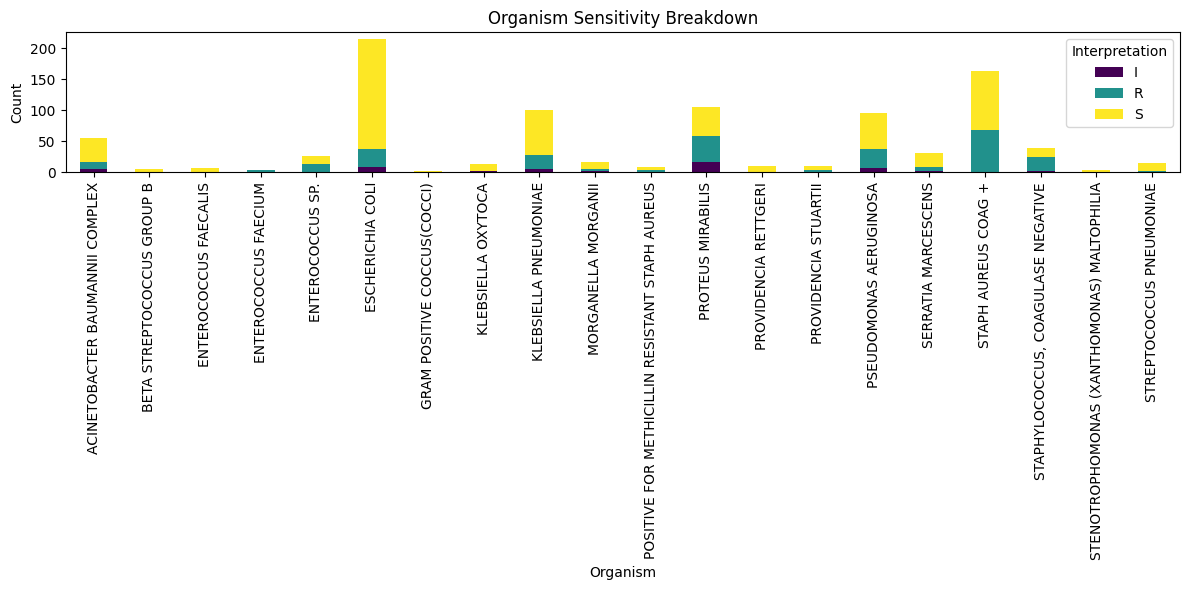

In [168]:
patient_microbio_df = filtered_patients_df.merge(microbiology_events_df, on='subject_id')
# Count interpretations by organism
interpretation_counts = patient_microbio_df.groupby(["org_name", "interpretation"]).size().unstack(fill_value=0)

# Plot a stacked bar chart
interpretation_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Organism Sensitivity Breakdown")
plt.xlabel("Organism")
plt.ylabel("Count")
plt.legend(title="Interpretation")
plt.tight_layout()
plt.show()

In [176]:
patient_microbio_df['org_name'].value_counts()
patient_microbio_df.shape

(1924, 24)

ConversionError: Failed to convert value(s) to axis units: array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
      dtype=object)

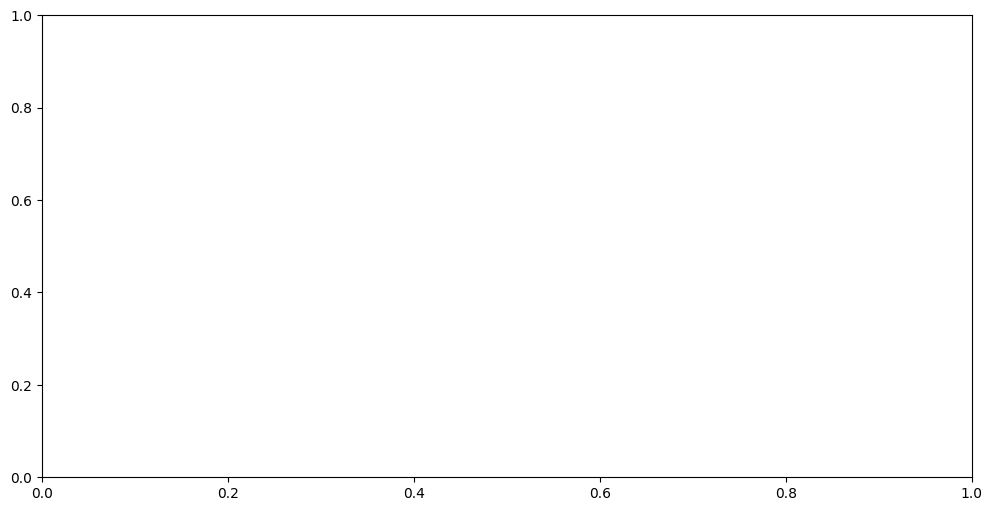

In [175]:

# Filter data for organisms
ecoli_data = patient_microbio_df[patient_microbio_df['org_name'] == 'ESCHERICHIA COLI']
staph_data = patient_microbio_df[patient_microbio_df['org_name'] == 'STAPH AUREUS COAG +'] 
proteus_data = patient_microbio_df[patient_microbio_df['org_name'] == 'PROTEUS MIRABILIS'] 
# Group by date of death for ESCHERICHIA COLI
ecoli_trends = ecoli_data.groupby('dod')['org_name'].count()
staph_trends = staph_data.groupby('dod')['org_name'].count()
proteus_trends = proteus_data.groupby('dod')['org_name'].count()

# Clean up date format
ecoli_trends.index = pd.to_datetime(ecoli_trends.index).strftime('%m-%d-%Y')
staph_trends.index = pd.to_datetime(staph_trends.index).strftime('%m-%d-%Y') 
proteus_trends.index = pd.to_datetime(proteus_trends.index).strftime('%m-%d-%Y')     

# # Plot a time series
plt.figure(figsize=(12, 6))
# plot the organism trends data
plt.plot(ecoli_data.index, ecoli_data.values, color="blue")
plt.plot(staph_data.index, staph_data.values, color="red")
plt.plot(proteus_data.index, proteus_data.values, color="green")

# plt.plot(infection_trends.index, infection_trends.values, color="red")
plt.title("Number of Infections Over Time")
plt.xlabel("Date of Death")
plt.ylabel("Number of Cases")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Antibiotic Resistence Heatmap

C:\Users\jeffrey.dewitt\AppData\Local\Temp\ipykernel_27296\1986163985.py:22: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



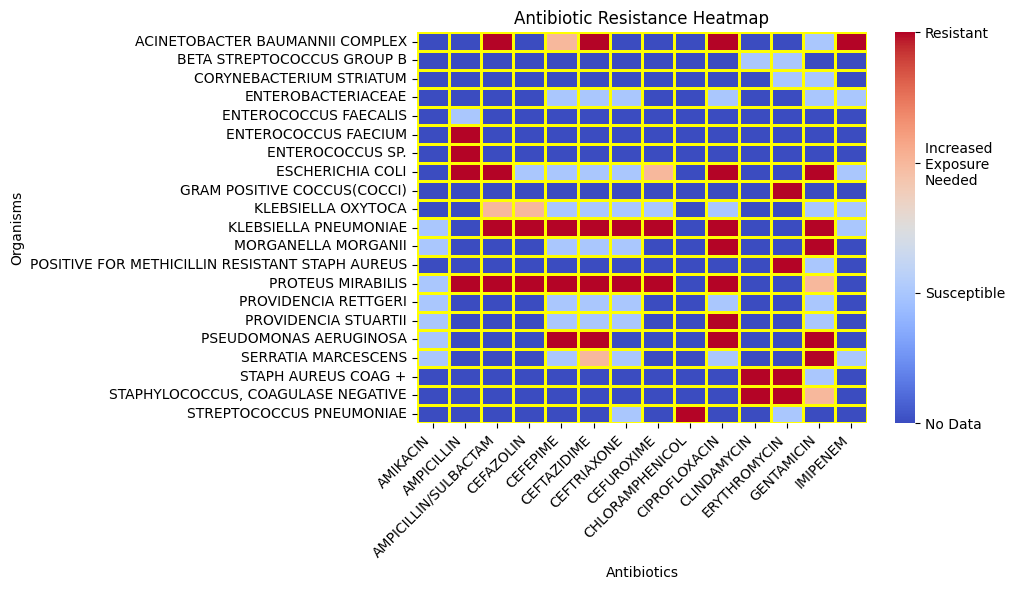

In [ ]:
# Replace NaN values with 0
microbiology_events_df['interpretation'] = microbiology_events_df['interpretation'].replace('NaN', 0)
microbiology_events_df.head()

# Step 1: Define priority mapping for interpretation (NaN has the lowest priority)
priority_mapping = {"R": 3, "I": 2, "S": 1, np.nan: 0}
microbiology_events_df["priority"] = microbiology_events_df["interpretation"].map(priority_mapping)

# Step 2: Resolve duplicates (if any) by keeping the highest priority interpretation
priotity_data = microbiology_events_df.sort_values("priority", ascending=False).drop_duplicates(subset=["org_name", "ab_name"])

# Sort by ab_name in ascending order and keep the top 50 rows
priotity_data = priotity_data.sort_values("ab_name").reset_index(drop=True)
priotity_data = priotity_data[:100]

# Step 3: Pivot the priority_data to create a heatmap-ready table
pivot = priotity_data.pivot(index="org_name", columns="ab_name", values="interpretation")

# # Step 4: Define color mapping, including NaN
color_map = {"S": 1.0, "I": 2.0, "R": 3.0, np.nan: 0.0}  # NaN mapped to white
# Ensure NaN is handled in the pivot table when applying colors
heatmap_colors = pivot.applymap(lambda x: color_map.get(x, "white"))
heatmap_colors.head()

# setting the parameter values 
linewidths = 2
linecolor = "yellow"

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_colors, 
    cmap="coolwarm", 
    linewidths=linewidths, 
    linecolor=linecolor
)

# Customize the colorbar
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['No Data', 'Susceptible', 'Increased \nExposure \nNeeded', 'Resistant'])

# Add a title and axis labels
plt.title("Antibiotic Resistance Heatmap")
plt.xlabel("Antibiotics")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Organisms")
plt.tight_layout()
plt.show()


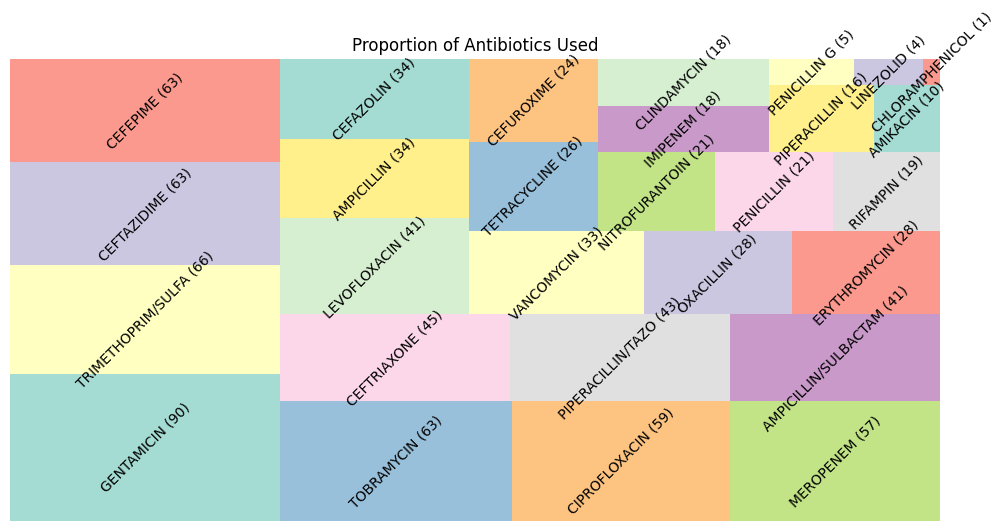

In [ ]:
import squarify

# Prepare data for treemap
antibiotic_counts = microbiology_events_df["ab_name"].value_counts()
labels = [f"{antibiotic} ({count})" for antibiotic, count in zip(antibiotic_counts.index, antibiotic_counts.values)]

# Plot the treemap
plt.figure(figsize=(12, 6))
squarify.plot(
    sizes=antibiotic_counts.values, 
    label=labels, 
    alpha=0.8, 
    color=sns.color_palette("Set3", len(labels)),
    text_kwargs={'fontsize': 10, 'rotation': 45}
)
plt.title("Proportion of Antibiotics Used")
plt.axis("off")
plt.show()